In [56]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import geopandas as gpd
import numpy as np
from shapely.geometry import Point,Polygon

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from flask import Flask,request,render_template

def dict_to_df(path,neighbourhood):
    '''This function reads stored dictionaries from google api search and convert to a dataframe
    Arguments
    Input 
    path: path of the dictionary
    neighbourhood: neighbourhood dataframe containing census data
    Returns
    df: converted dataframe
    '''
    dictionary=np.load(path,allow_pickle=True).item()
    names=[]
    counts=[]
    for key,val in dictionary.items():
        names.append(key)
        counts.append(len(val['results']))
    df=pd.DataFrame({'name':names,'count':counts})
    df=df.sort_values(by=['name'])
    df.index=neighbourhood.index
    df=df.drop(['name'],axis=1)
    return df

def col_select(df,column_to_compare,n):
    '''This function compares a column agains all column of another dataframe and select high correlated columns
    Input
    df: dataframe whose columns are being compared
    column_to_compare: a column against which other columns are compared
    n: number of colums to keep
    Returns
    col_df: a dataframe with highly correlated columns & values
    '''
    correlations=[]
    for col in df.columns:
        cor=df[col].corr(column_to_compare,method='spearman')
        correlations.append(cor)
    abs_correlations=[abs(val) for val in correlations]
    col_selected_df=pd.DataFrame({'feature':df.columns,'correlation':correlations,'abs':abs_correlations})
    col_selected_df=col_selected_df.sort_values(by=['abs'],ascending=False)
    col_selected_df=col_selected_df.iloc[0:n,:]
    return col_selected_df

def sel_n_pca(df,col_selected):
    ''' This function determines the number of pca components required to explain at least 95% of variance
    Input
    df: Input dataframe
    col_selected: name of the column of the dataframe to be used
    Returns:
    pca_components: principal components 
    i: number of components that explains 95% variance
    '''
    subset=df[col_selected]
    scaler = StandardScaler()
    pca = PCA()
    pipeline = make_pipeline(scaler,pca)
    pipeline.fit(subset)
    pca_components=pipeline.transform(subset)
    features = range(pca_components.shape[1])
    explained_var=pca.explained_variance_/sum(pca.explained_variance_)*100
    
    explained_sum=0
    for i in range(1,(len(explained_var)+1)):
        explained_sum=explained_sum+explained_var[i-1]
        if explained_sum>95:
            break
    return pca_components,i

def sel_num_clust(pca_components,n_components):
    '''This function accepts principal components matrix and number of components to use
    It performs kmeans clustering with different number of clusters and select the optimum number
    of clusters
    Input:
    pca_components: pca_components after pca transformation
    n_components: n components that explains at least 95% of variation
    
    '''
    inertias = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, init='random',n_init=100)
        kmeans.fit(pca_components[:,0:n_components])
        inertias.append(kmeans.inertia_)
    diff=abs(np.diff(inertias))
    diff_first=diff[0]
    threshold=diff_first*.05
    for i in range(1,len(diff)):
        if diff[i]<threshold:
            return i
            break

def plot_map(pca_components,n_components,n_clust,neighbourhood,df_toronto,query_df):
    ''' This function plots toronto neighbourhoods together with the counts for the search query.
    Two neighbourhoods has the same color if they are in the same cluster
    Input:
    pca_components: Pca components after PCA transformation
    n_compoments: number of PCA components to be used
    neighbourhood: census dataframe
    df_toronto: map dataframe
    query_df: query dataframe
    Returns:
    cluster_labels: A dataframe containing the label and color of each neighbourhood
    
    '''    
    X=pca_components[:,0:n_components]
    kmeans = KMeans(n_clusters=n_clust, init='random',n_init=100).fit(X)
    cluster_labels=pd.DataFrame({'name':neighbourhood.index,'label':kmeans.labels_})
    color_selected = color_shortlisted[0:n_clust]
    cluster_labels['color']=cluster_labels['label'].map(dict(zip(range(n_clust),color_selected)))
    geo_query=gpd.GeoDataFrame(query_df,geometry=geometry_points)
    fig,ax=plt.subplots(figsize=(15,15))
    df_toronto.plot(ax=ax,edgecolor='black',alpha=0.5,color=cluster_labels['color'],legend=True)
    # geo_query.plot(ax=ax,markersize=geo_query['count']*10,alpha=.5)
    for x, y, label in zip(geo_query.geometry.x, geo_query.geometry.y, query_df['count']):
        ax.annotate(label, xy=(x, y), xytext=(-5,-4),  textcoords="offset points")
    plt.savefig('./static/1.cluster_map.png',transparent=True,bbox_inches="tight",dpi=300)
    plt.show()
    return cluster_labels

def plot_cluster_counts(cluster_labels):
    ''' This function plots the number of neighbourhoods in each cluster
    Input:
    cluster_labels: A dataframe containing neighbourhoods and their cluster labels
    Returns:
    None
    '''
    cluster_counts=cluster_labels['color'].value_counts().sort_values(ascending=False)
    plt.bar(height=cluster_counts,x=cluster_counts.index,color=cluster_counts.index)
    plt.grid(True)
    plt.savefig('./static/2.cluster_counts.png',transparent=True,bbox_inches="tight",dpi=300)
    plt.show()

def find_order(query_df,cluster_labels):
    query_df['color']=cluster_labels['color'].values
    means=query_df.groupby(['color'])['count'].median().sort_values(ascending=False)
    color_order=means.index.values
    return color_order


def plot_count_distribution(query_df,cluster_labels,color_order):
    ''' The function plot the distribution of query counts in each cluster
    Input:
    query_df: query count dataframe
    cluster_labels: dataframe containing neighbourhoods and clusters
    Returns:
    None
    '''
    query_df['color']=cluster_labels['color'].values
    ax = sns.violinplot(x="color", y="count",data=query_df,order=color_order,palette=color_order,alpha=.5)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Query counts')
    plt.grid(True)
    plt.savefig('./static/3.count_distribution.png',transparent=True,bbox_inches="tight",dpi=300)
    plt.show()


def plot_feature_median(neighbourhood,cols_selected,cluster_labels,color_order):
    '''This functions calculate and plot the median values of important features in each cluster
    Input:
    neighbourhood: Original census dataframe
    col_selected: highly correlated columns 
    cluster_labels: neighbourhood dataframe containing labels
    Output:
    None
    
    '''
    subset_label=neighbourhood[cols_selected]
    subset_label['label']=cluster_labels['color'].values
    fig = plt.figure(figsize=(15,25))
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    for i in range(1, 11):
        ax = fig.add_subplot(5, 2, i)
        sns.violinplot(y=subset_label.iloc[:,i-1],x=subset_label['label'],order=color_order,palette=color_order,alpha=0.5)
        ax.set_title(subset_label.columns[i-1],fontweight='bold')
        ax.set_ylabel('Population')
        ax.set_xlabel('Cluster')
        ax.grid()
    plt.savefig('./static/4.feature_median.png',transparent=True,bbox_inches="tight",dpi=300)
    plt.show()


In [37]:
# Read the stored files
neighbourhood=pd.read_csv('./static/data/neighbourhood-cleaned-2.csv',sep=',',index_col=0)
df_toronto=gpd.read_file("./static/data/Neighbourhoods.geojson")
df_toronto=df_toronto.sort_values(by=['AREA_NAME'])
geometry_points=[Point(xy) for xy in zip(df_toronto['LONGITUDE'],df_toronto['LATITUDE'])]
color_shortlisted=['red','blue','green','cyan','orange','magenta','olive','yellow','lime','purple']
stored_dict=pd.read_csv('./static/data/stored_dict.csv',sep=',',index_col=0)

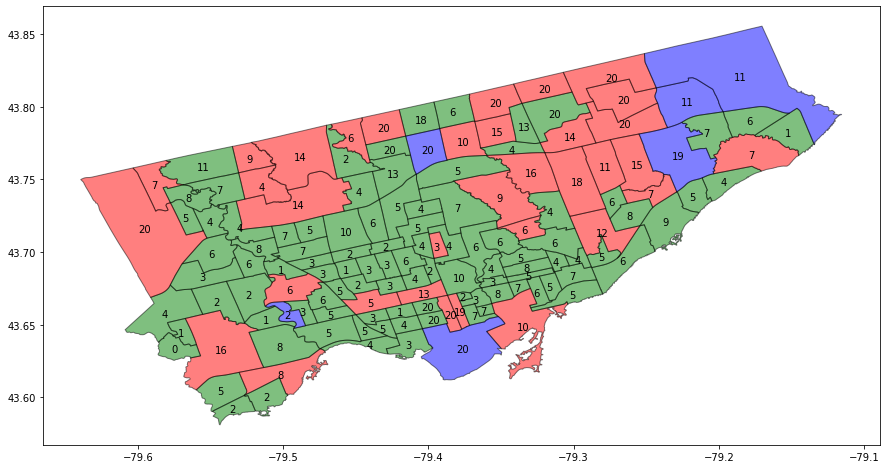

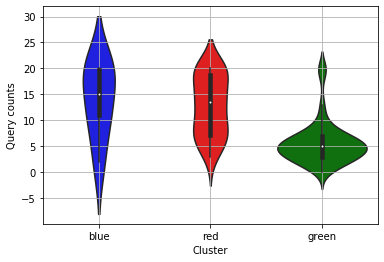

/Users/Vineeth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


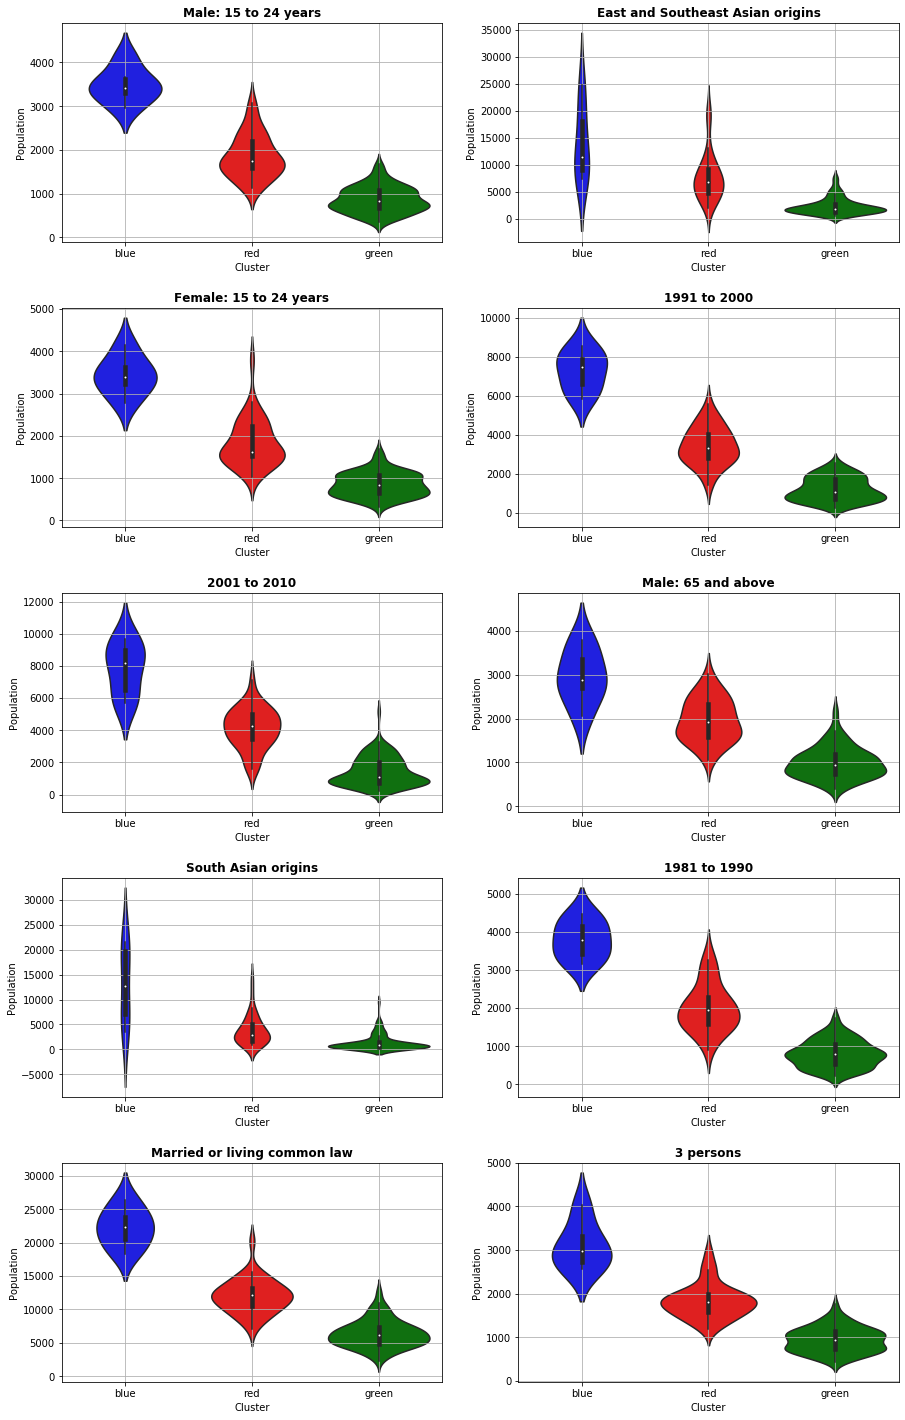

In [60]:
query_df=dict_to_df('./static/google_api/chinese_rest_dict.npy',neighbourhood)
highly_correlated_features_df = col_select(neighbourhood,query_df['count'],10)
pca_components , n_components = sel_n_pca(neighbourhood,highly_correlated_features_df['feature'])
n_clust = sel_num_clust(pca_components,n_components)
cluster_labels = plot_map(pca_components,n_components,n_clust,neighbourhood,df_toronto,query_df)
color_order=find_order(query_df,cluster_labels)
plot_count_distribution(query_df,cluster_labels,color_order)
plot_feature_median(neighbourhood,highly_correlated_features_df['feature'],cluster_labels,color_order)
